# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from copy import deepcopy
from bs4 import BeautifulSoup
from unicodedata import normalize as uni_normalize
from matplotlib import cm

# Working on HTML versions

## Parsing the HTML file
Let's first read the html file extracted from the REME PDF:

In [2]:
HTML_FILE = "docs/rep_metiers-12.html"

In [3]:
with open(HTML_FILE, "r") as reme_html:
    full_html = reme_html.read()

In [4]:
soup = BeautifulSoup(full_html)

## Extracting the positions of every p object

In [5]:
paragraphs = soup.find_all('p')

In [6]:
def get_pos(p_object):
    """
    Retrieves the position of a <p> object from its style attribute.
    Returns a pair (top, left) in pixels.
    """
    top, left = re.findall('[0-9]+', p_object.attrs['style'])
    return int(top), int(left)

In [7]:
# Map (top, left) --> <p> object
par_dict = {get_pos(par): par for par in paragraphs}
# List of all (top, left) locations
locations = list(par_dict.keys())
x_s, y_s = [x for x, y in locations], [y for x, y in locations]

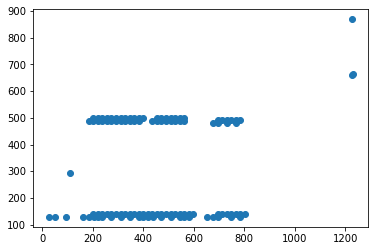

In [8]:
plt.scatter(x_s, y_s)

## Clustering into paragraphs

In [9]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance_matrix

/home/clement/.conda/envs/raep/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
X = np.array([x_s, y_s]).T
X.shape

(108, 2)

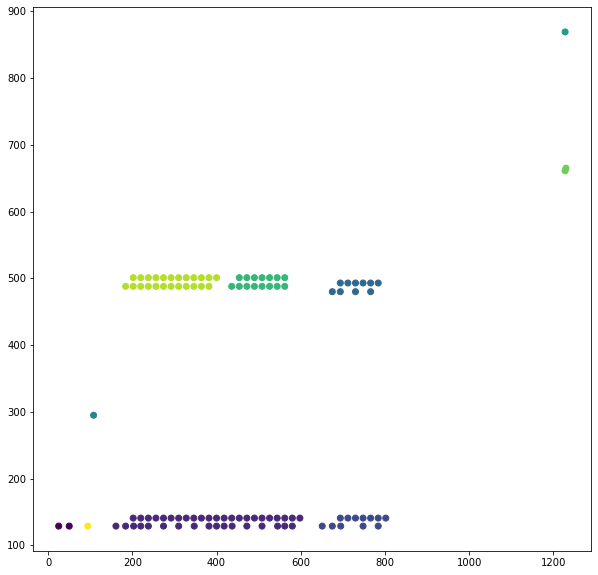

In [54]:
pred = AgglomerativeClustering(linkage="single", distance_threshold=37.5,
                               n_clusters=None,
                               affinity="l1").fit_predict(X)
plt.figure(figsize=(10, 10))
plt.scatter(x_s, y_s, c=pred)

In [55]:
n_clusters = pred.max() + 1
clusters = [[] for _ in range(n_clusters)]
for i, prediction in enumerate(pred):
    clusters[prediction].append(paragraphs[i])

## Visualizing clusters
We'll now create a copy the HTML page upon which will be drawn shapes to delimit the clusters in the doc.

In [57]:
cmap = cm.get_cmap('tab20')

In [58]:
for k, cluster in enumerate(clusters):
    # Assign a color to the cluster
    color = cmap(k / n_clusters, bytes=True)
    # Assign that color as background to all elements in that cluster
    for elem in cluster:
        elem['style'] += ";background-color:rgba({}, {}, {}, 0.3);".format(*color)
        # We also add an artificial attribute to indicate the cluster
        elem['cluster'] = k

In [18]:
soup.body.find_all('div', recursive=False)

[<div id="page13-div" style="position:relative;width:892px;height:1262px;">
 <img alt="background image" height="1262" src="rep_metiers013.png" width="892"/>
 <p class="ft00" cluster="9" style="position:absolute;top:94px;left:129px;white-space:nowrap;background-color:rgba(23, 190, 207, 0.3);">Enseignant </p>
 <p class="ft01" cluster="4" style="position:absolute;top:108px;left:295px;white-space:nowrap;background-color:rgba(148, 103, 189, 0.3);"> [ code fiche EFV01 ]</p>
 <p class="ft02" cluster="0" style="position:absolute;top:25px;left:129px;white-space:nowrap;background-color:rgba(31, 119, 180, 0.3);"><b>Éducation et formation </b></p>
 <p class="ft02" cluster="0" style="position:absolute;top:50px;left:129px;white-space:nowrap;background-color:rgba(31, 119, 180, 0.3);"><b>tout au long de la vie</b></p>
 <p class="ft03" cluster="7" style="position:absolute;top:1228px;left:661px;white-space:nowrap;background-color:rgba(127, 127, 127, 0.3);">[</p>
 <p class="ft04" cluster="7" style="posi

We'll save the new HTML file so that we can open it with a browser:

In [59]:
NEW_HTML_FILE = "visu_docs/page12.html"
with open(NEW_HTML_FILE, "w") as file:
    file.write(str(soup))